In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import importlib
import iris_segmentation_utils
importlib.reload(iris_segmentation_utils)
from iris_segmentation_utils import *
import cv2
from skimage.morphology import remove_small_objects

# Load data

In [2]:
def load_image(image_path):
    try:
        img = Image.open(f"{image_path}")
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None
    
data=pd.read_csv('data/image_data.csv')
data['image'] = data['image_path'].apply(lambda x: load_image(f'data/{x}'))
data.head()

person   eye                     image_path  \
0       1  left  images/person1_left_image.bmp   
1       1  left  images/person1_left_image.bmp   
2       1  left  images/person1_left_image.bmp   
3       1  left  images/person1_left_image.bmp   
4       1  left  images/person1_left_image.bmp   

                                               image  
0  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...  
1  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...  
2  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...  
3  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...  
4  <PIL.BmpImagePlugin.BmpImageFile image mode=L ...

In [5]:
data['mean_brightness'] = data['image'].apply(iris_brightness_1)
data.head()

person   eye                     image_path  \
0       1  left  images/person1_left_image.bmp   
1       1  left  images/person1_left_image.bmp   
2       1  left  images/person1_left_image.bmp   
3       1  left  images/person1_left_image.bmp   
4       1  left  images/person1_left_image.bmp   

                                               image  mean_brightness  
0  [[248, 248, 245, 239, 238, 242, 247, 237, 248,...         100.7944  
1  [[248, 248, 245, 239, 238, 242, 247, 237, 248,...         100.7944  
2  [[248, 248, 245, 239, 238, 242, 247, 237, 248,...         100.7944  
3  [[248, 248, 245, 239, 238, 242, 247, 237, 248,...         100.7944  
4  [[248, 248, 245, 239, 238, 242, 247, 237, 248,...         100.7944

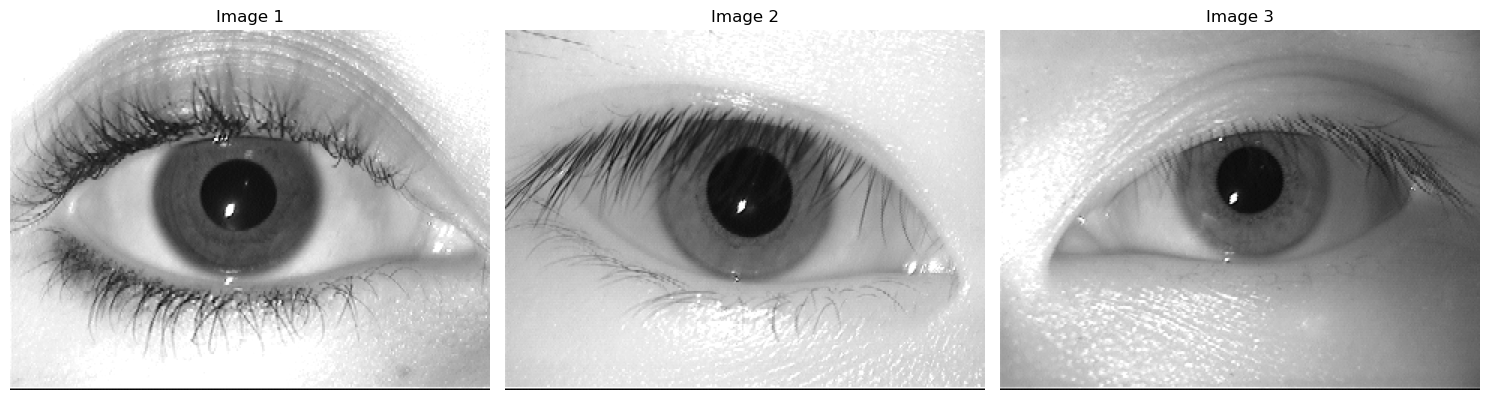

In [3]:
sample_images = data['image'].sample(3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#displaying sample images
for i, ax in enumerate(axes):
    ax.imshow(sample_images.iloc[i], cmap='gray')
    ax.axis('off') 
    ax.set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

### Converting all images to grayscale

In [4]:
data['image'] = data['image'].apply(lambda x: convert_to_grayscale(x))

### Binarization experiments

binarization for x_i: 1.00


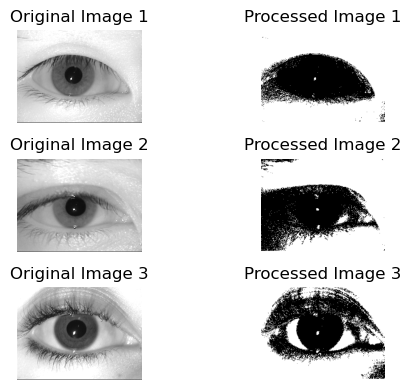

binarization for x_i: 1.10


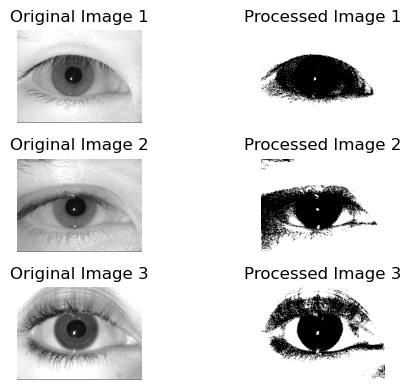

binarization for x_i: 1.20


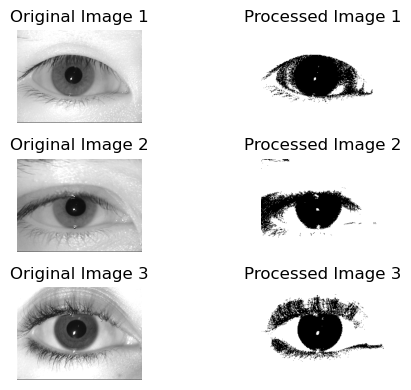

binarization for x_i: 1.30


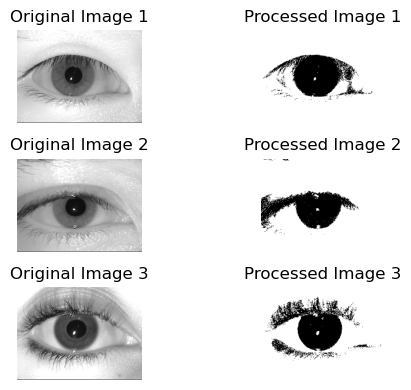

binarization for x_i: 1.40


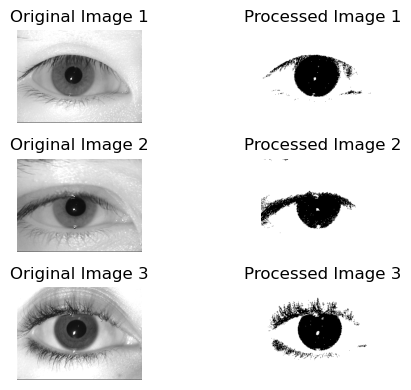

binarization for x_i: 1.50


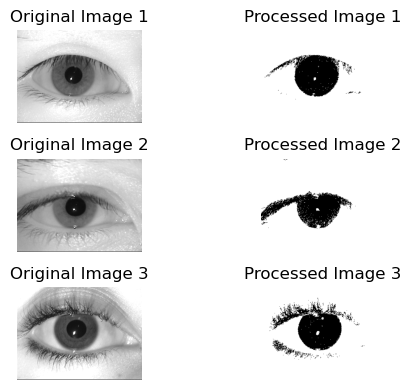

binarization for x_i: 1.60


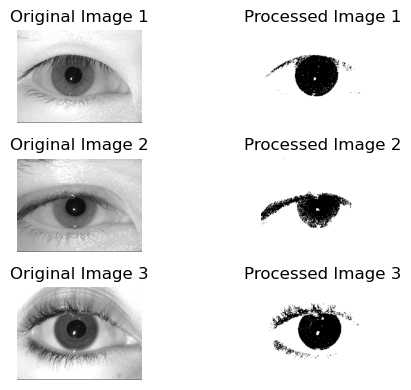

binarization for x_i: 1.70


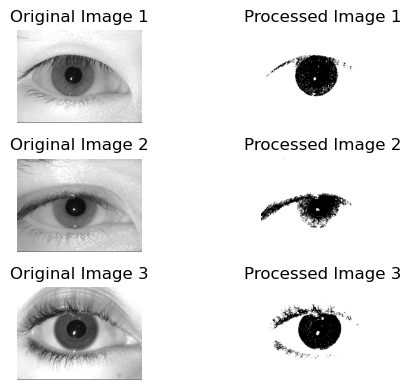

binarization for x_i: 1.80


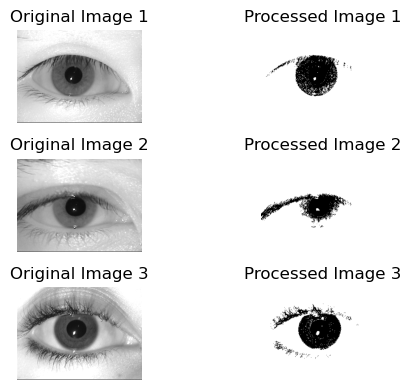

binarization for x_i: 1.90


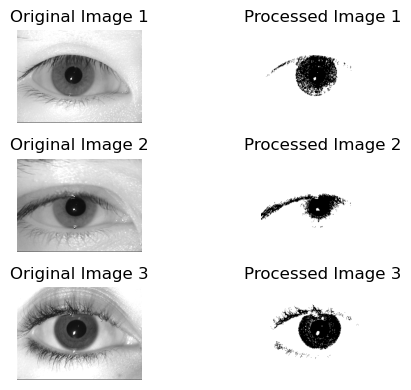

binarization for x_i: 2.00


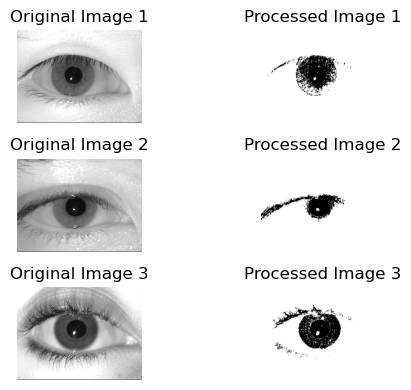

In [6]:
X_I=np.linspace(1,2, 11) #unifromly distributed values between 1 and 2
sample_images = data['image'].sample(3)
for x_i in X_I:
    print(f"binarization for x_i: {x_i:.2f}")
    processed_images = sample_images.apply(lambda x: iris_binarization(x, x_i))
    plot_images_experiments(sample_images, processed_images, n=3)

observation: lighter eye colors are fading when X_I is more than 1.5

Brightness: 403    167.025964
276    173.873294
17     178.387422
Name: image, dtype: float64


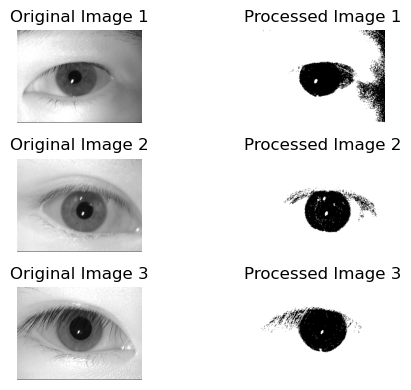

In [13]:
X_I=1.4
sample_images = data['image'].sample(3)
processed_images = sample_images.apply(lambda x: iris_binarization(x, X_I))
print('Brightness:', sample_images.apply(lambda x: compute_binarization_threshold(x)))
plot_images_experiments(sample_images, processed_images, n=3)

Brightness: 294    146.461510
45     169.341146
296    159.844232
Name: image, dtype: float64


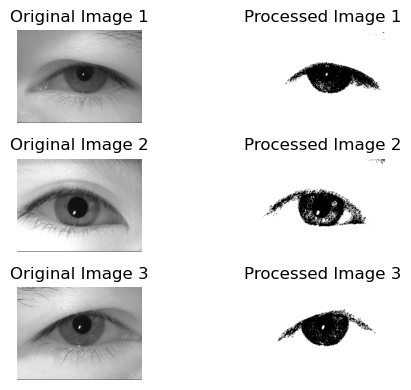

In [14]:
X_I=1.6
sample_images = data['image'].sample(3)
processed_images = sample_images.apply(lambda x: iris_binarization(x, X_I))
print('Brightness:', sample_images.apply(lambda x: compute_binarization_threshold(x)))
plot_images_experiments(sample_images, processed_images, n=3)

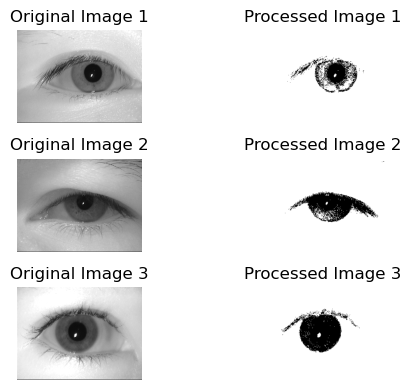

In [26]:
X_I=1.8 #for darker eyes
sample_images = data['image'].sample(3)
processed_images = sample_images.apply(lambda x: iris_binarization(x, X_I))
plot_images_experiments(sample_images, processed_images, n=3)

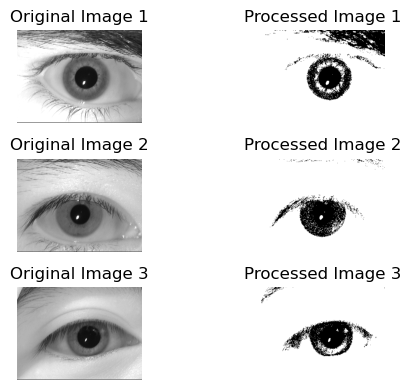

In [49]:
X_I=1.6 #ok for light eyes
sample_images = data['image'].sample(3)
processed_images = sample_images.apply(lambda x: iris_binarization(x, X_I))
plot_images_experiments(sample_images, processed_images, n=10, figsize=(6,4))

searching for X_I dynamically by computing mean brightness of photo

0.45383135496351007
0.39527215863721055
0.3715181114250094
0.4830628584674842
0.45092349815749533
0.39527215863721055
0.4000413395532294
0.45383135496351007
0.41326815968981373
0.4675078315349809


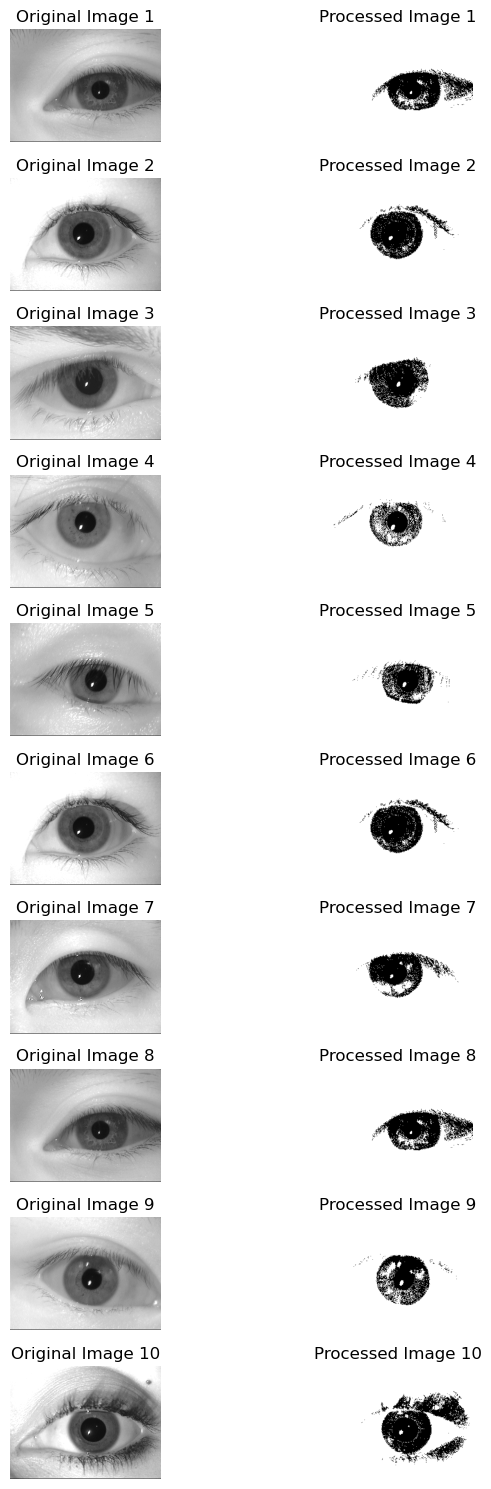

In [55]:
sample_images = data['image'].sample(10)
X_I_values = sample_images.apply(calculate_iris_threshold)
processed_images = pd.Series([iris_binarization(img, x_i) for img, x_i in zip(sample_images, X_I_values)],
    index=sample_images.index)
plot_images_experiments(sample_images, processed_images, n=10, figsize=(8,15))

In [53]:
X_I_values

292    1.800000
337    1.705027
371    1.686123
59     1.746443
398    1.678227
111    1.614796
128    1.776901
125    1.776901
423    1.600000
229    1.745003
Name: image, dtype: float64

### trying different morphologies

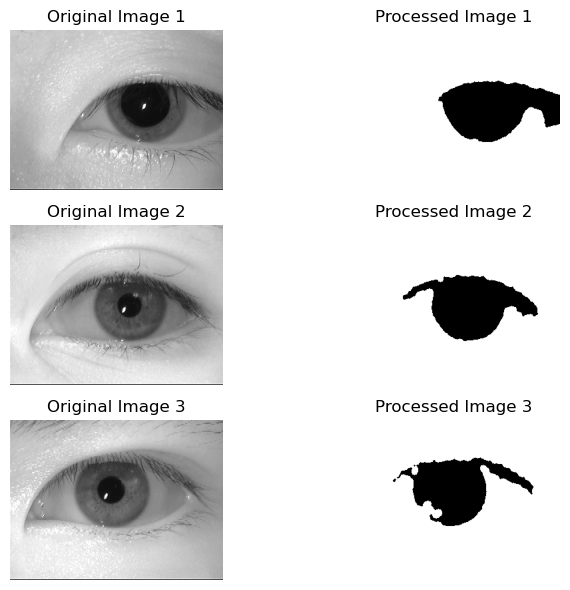

In [383]:
sample_images = data['image'].sample(3)
X_I_values = sample_images.apply(calculate_iris_threshold)
binarized_images = pd.Series([iris_binarization(img, x_i) for img, x_i in zip(sample_images, X_I_values)],
    index=sample_images.index)

processed_images=binarized_images.apply(lambda x: iris_morphology(x, open_kernel_size=9, close_kernel_size=3))
plot_images_experiments(sample_images, processed_images, n=10, figsize=(8,6))

### Canny edge detection on image with morphology applied

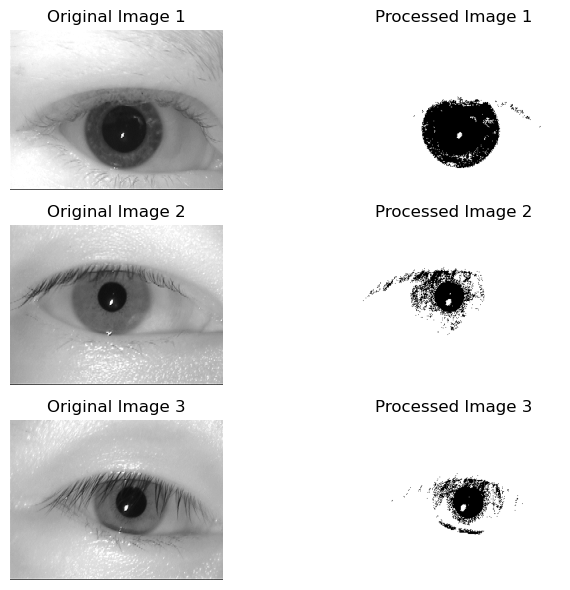

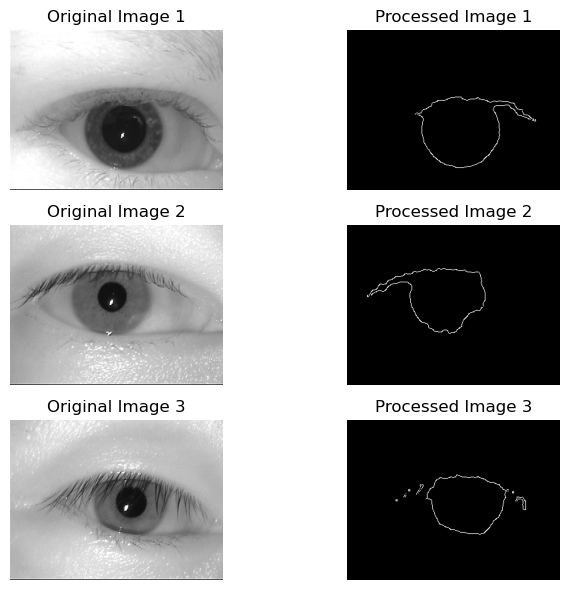

In [349]:
binarized_images=sample_images.apply(lambda x: binarize_iris_manual(x) )
plot_images_experiments(original_images=sample_images, processed_images=binarized_images, n=3, figsize=(8,6))

canny_edges = processed_images.apply(lambda x: detect_canny_edges(x, low_threshold=10, high_threshold=120))
plot_images_experiments(
        original_images=sample_images, 
        processed_images=canny_edges,
        n=3, figsize=(8,6)
    )

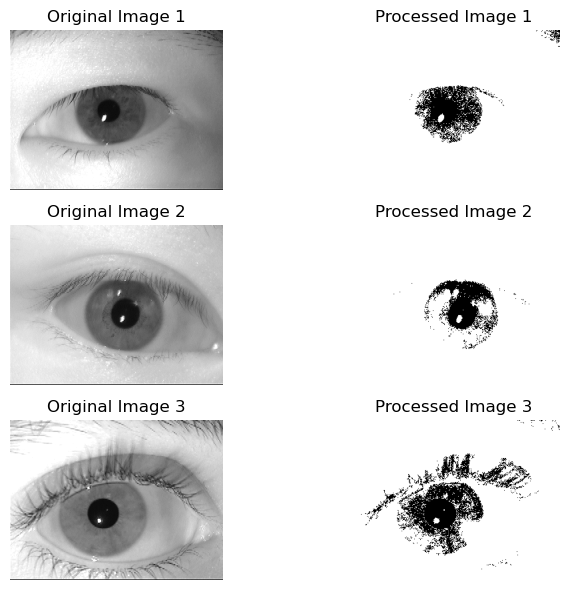

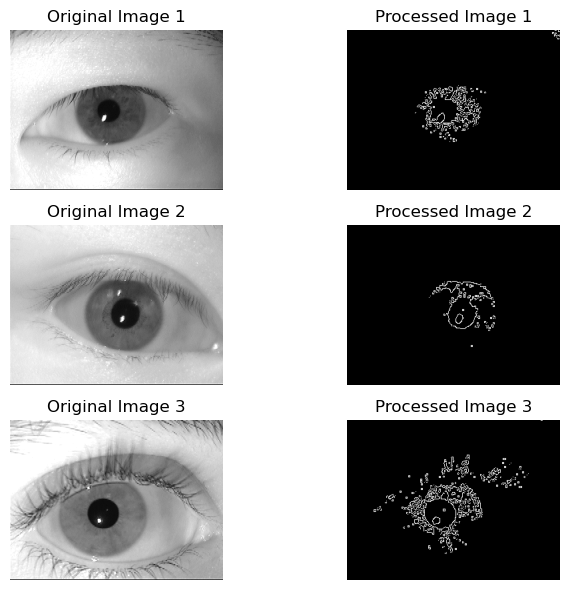

In [436]:
sample_images = data['image'].sample(3)
binarized_images=sample_images.apply(lambda x: binarize_iris_manual(x) )
plot_images_experiments(original_images=sample_images, processed_images=binarized_images, n=3, figsize=(8,6))

processed_images = binarized_images.apply(lambda x: detect_canny_edges(x, low_threshold=50, high_threshold=100))
plot_images_experiments(
        original_images=sample_images, 
        processed_images=processed_images,
        n=3, figsize=(8,6)
    )

### Iris detection - Hough algorithm

trying detecting circles with Hough on processed images (binarized, after morphology and edge detection)

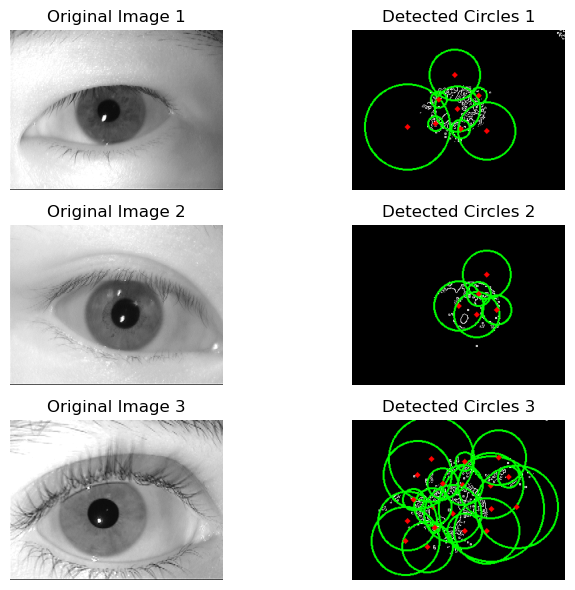

In [437]:
n = len(sample_images)
fig, axes = plt.subplots(n, 2, figsize=(8,6))

for i in range(n):
    orig = sample_images.iloc[i]
    processed = processed_images.iloc[i]

    circles = find_hough_circles_all(processed)
    output = cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR)

    if len(circles) > 0:
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)
            cv2.circle(output, (x, y), 2, (0, 0, 255), 3)

    axes[i, 0].imshow(orig, cmap='gray')
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title(f"Detected Circles {i+1}" )
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


detecting iris circle with pre-defined conditions

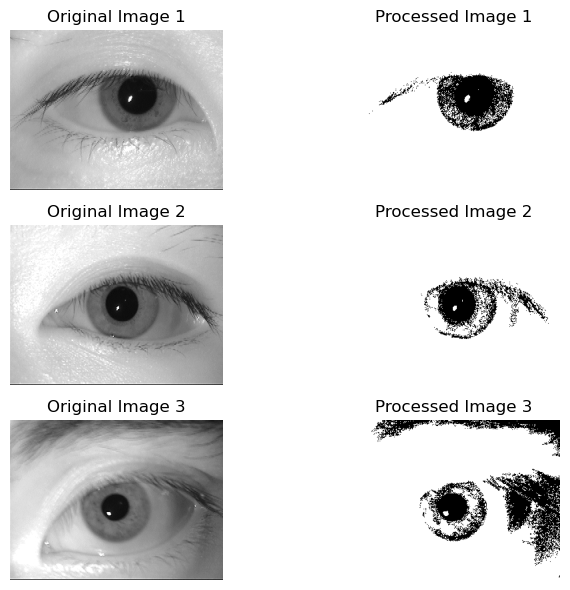

Detected circles: [(191, 96, 58)]
Detected circles: [(167, 117, 52)]
Detected circles: [(157, 130, 48)]


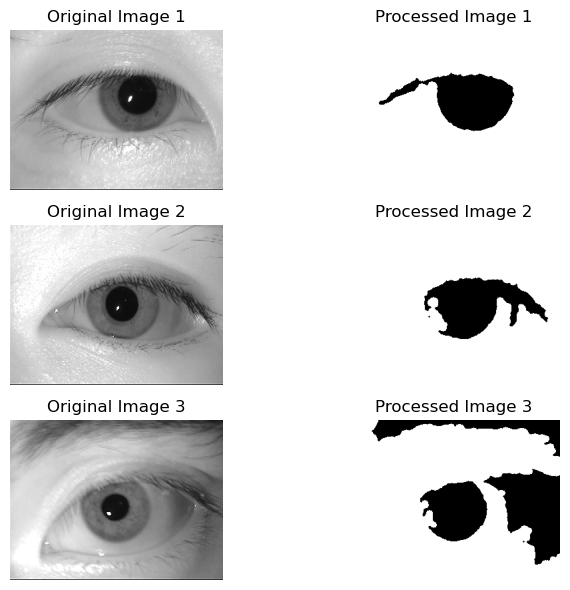

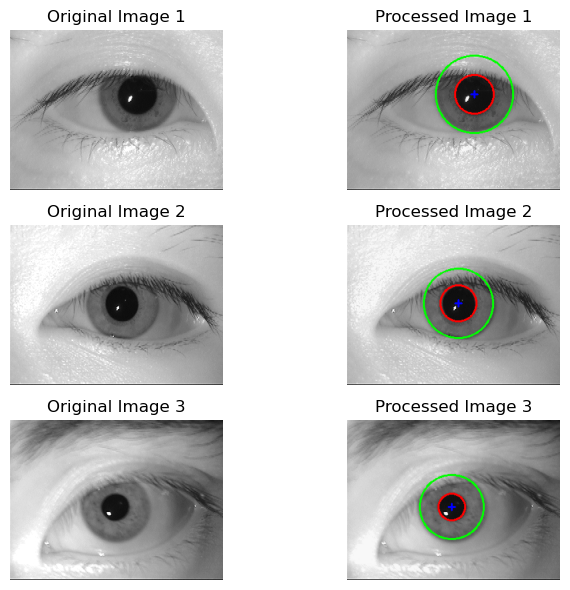

In [448]:
sample_images = data['image'].sample(3)
binarized_images=sample_images.apply(lambda x: binarize_iris_manual(x) )
plot_images_experiments(original_images=sample_images, processed_images=binarized_images, n=3, figsize=(8,6))

result = sample_images.apply(lambda x: iris_pipeline(x))
canny_edges = result.apply(lambda x: x[0])
processed_images = result.apply(lambda x: x[1])
image_with_circles= result.apply(lambda x: x[2])

plot_images_experiments(original_images=sample_images, processed_images=processed_images, n=3, figsize=(8,6))
plot_images_experiments(original_images=sample_images, processed_images=image_with_circles, n=3, figsize=(8,6))

#### Isolating the iris region

Detected circles: [(155, 124, 60)]
Detected circles: [(141, 140, 57)]
Detected circles: [(174, 113, 47)]


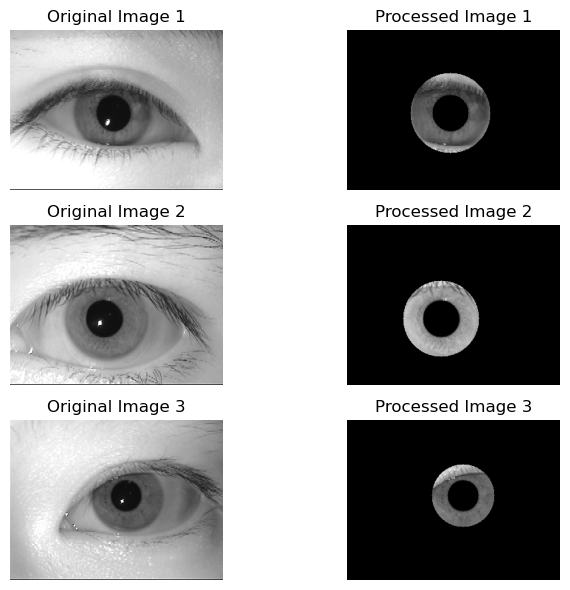

In [38]:
sample_images = data['image'].sample(3)
result = sample_images.apply(lambda x: iris_pipeline(x))
extracted_iris=result.apply(lambda x: x[4])

plot_images_experiments(original_images=sample_images, processed_images=extracted_iris, n=3, figsize=(8,6))

### Iris to rectangular

Detected circles: [(138, 148, 56)]
Detected circles: [(171, 110, 53)]
Detected circles: [(173, 110, 35)]


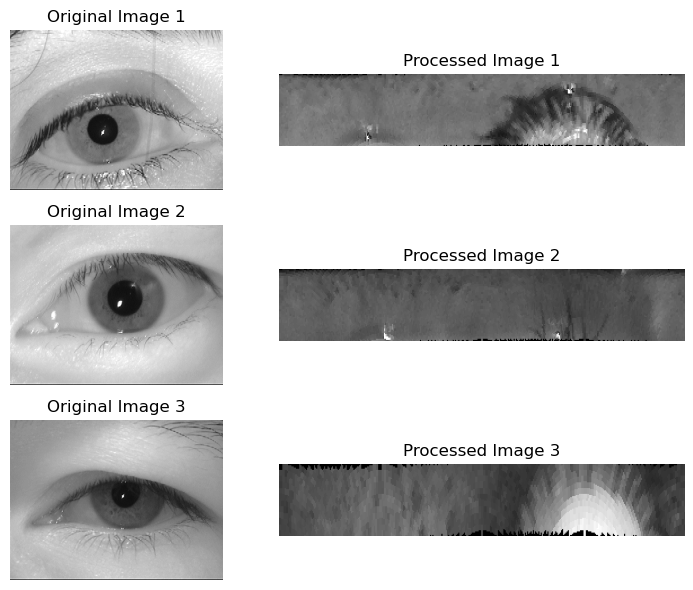

In [80]:
sample_images = data['image'].sample(3)
result = sample_images.apply(lambda x: iris_pipeline(x))
unwrapped_iris=result.apply(lambda x: x[5])

plot_images_experiments(original_images=sample_images, processed_images=unwrapped_iris, n=3, figsize=(8,6))